# Inferring the Earth's tilt from day lengths

In this article, I will use some scientific computing tools to infer the [axial tilt](https://en.wikipedia.org/wiki/Axial_tilt) of the Earth based on how long days last. There is no scientific novelty here: it's only a little challenge I set up for myself, because I wanted to practice some physical modeling and data analysis using only a minimal set of scientific tools.

**Concepts:** curve-fitting, least-squares regression, numerical optimization, symbolic computing, numerical integration, (Bayesian) inference, Laplace Method, (Euclidean) geometry, trigonometry.

**Tools:** [Python](https://www.python.org/), [NumPy](https://numpy.org/), [SciPy](https://www.scipy.org/), [SymPy](https://www.sympy.org/), [Matplotlib](https://matplotlib.org/), [Jupyter](https://jupyter.org/), [GeoGebra](https://www.geogebra.org/).

I expect this article to be read by people from many different backgrounds. If some things seem obvious to you, please don't take it as an insult to your intelligence. Enjoy your read!

**Disclaimer:** astronomy is not my specialty, and I did most of this work while having very little access to the Internet. Expect some unconventional notation!

#### Table of Contents:

* [Introduction](#Introduction)
* [Collecting data](#Collecting-data)
* [Model-independent utilities](#Model-independent-utilities)
    * [Datasets](#Datasets)
    * [Parsing](#Parsing)
    * [Test error](#test-error)
    * [Miscellaneous](#Miscellaneous)
* [ Model 1: a perfect half-sphere in sunlight](#Model-1:-a-perfect-half-sphere-in-sunlight)
    * [Physical Model](#Physical-Model)
    * [Framing Model 1 as a linear regression](#Framing-Model-1-as-a-linear-regression)
    * [Model 1: implementing the regression](#Model-1:-implementing-the-regression)
    * [Model 1: results](#Model-1:-results)
* [Model 1 bis: non-linear least-squares regression](#Model-1-bis:-non-linear-least-squares-regression)
    * [Implementing the regression by numerical optimization](#Implementing-the-regression-by-numerical-optimization)
    * [Model 1 bis: results](#Model-1-bis:-results)
* [Model 2: accounting for an excess angle $\epsilon$](#Model-2:-accounting-for-an-excess-angle-$\epsilon$)
    * [Refined physical model](#Refined-physical-model)
    * [Implementing the regression](#Implementing-the-regression)
    * [Model 2: results](#Model-2:-results)
    * [What might be causing $\epsilon$?](#What-might-be-causing-$\epsilon$?)
* [Bayesian analysis](#Bayesian-analysis)
    * [A review of Bayesian inference](#A-review-of-Bayesian-inference)
    * [Bayesian analysis of Model 1 bis](#Bayesian-analysis-of-Model-1-bis)
    * [Bayesian analysis of Model 2](#Bayesian-analysis-of-Model-2)
    * [Model comparison](#Model-comparison)
* [Confession: the math error in the model](#Confession:-the-math-error-in-the-model)
* [Conclusion](#Conclusion)

## Introduction

![Illustration of the Earth orbit around the Sun and axial tilt](../img/earth-tilt-orbit.jpg)

If you're any older than 1 year old, you've probably noticed that the **daylight length** (the duration between sunrise and sunset) varies depending on the time of the year: it reaches its maximum and minimum at solstices, and is about 12 hours at equinoxes. What's more, as you approach the Equator, this variation gets smaller and smaller: at the Equator, you get about 12 hours of daylight per day, all year long.

This, as well as seasons, is explained by the **Earth's tilt**: the axis of rotation of the Earth is not quite parallel to its axis of rotation around the Sun. The angle between these axes is called the _Earth's tilt_ or *obliquity*; I'll denote it $\alpha$ in this article.

This has prompted me to tackle the following problem: 

---

#### Problem statement

**_Can we, given the daylight lengths at various places and times around the globe, infer the Earth's tilt $\alpha$ reliably?_**

---

To answer this question, here's **what we'll do:**

* We will do some theoretical thinking, resulting in _**physical models**_ for relating our observation data to the Earth's tilt $\alpha$.
* We will run some _**inference algorithms**_ to fit our models to the data, resulting in estimations for $\alpha$. This will involve various tools for numerical and symbolic computing.
* These estimations will be accompanied by some visually-comforting data visualizations.
* We will **assess the reliability** of our estimations and models using prediction error and _**Bayesian analysis**_.

Here are some libraries we will use throughout this notebook:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as linalg

## Collecting data

To collect experimental data, I looked up the geographic coordinates of a handful of cities around the world, then went to a meteo website to manually collect daylight lengths at randomly selected days of the year 2019.

This section shows some code that assited me in this task - feel free to skip it.

I generated a JSON-formatted template, to be filled with daylight lengths for randomly selected places and locations.

In [2]:
import random
import datetime
import json
import io

N = 200 ## the number of samples we want to collect

cities = [ ## some cities scattered over the world (between polar circles though)
  {'name': 'New York', 'pos': [40.7128, -74.0060]},
  {'name': 'Beijing', 'pos': [39.9042, 116.4074]},
  {'name': 'Buenos Aires', 'pos': [-34.6037, -58.3816]},
  {'name': 'Lisboa', 'pos': [38.7223, -9.1393]},
  {'name': 'Makassar', 'pos': [-5.1477, 119.4327]},
  {'name': 'Ushuaia', 'pos': [-54.8019, -68.3030]},
  {'name': 'Mumbai', 'pos': [19.0760, 72.8777]},
  {'name': 'Istanbul', 'pos': [41.0082, 28.9784]},
  {'name': 'Nairobi', 'pos': [-1.2921, 36.8219]},
  {'name': 'Sydney', 'pos': [-33.8688, 151.2093]},
  {'name': 'Los Angeles', 'pos': [34.0522, -118.2437]},
  {'name': 'Cape Town', 'pos': [-33.9249, 18.4241]},
  {'name': 'Noumea', 'pos': [-22.2735, 166.4481]},
  {'name': 'Tokyo', 'pos': [35.6762, 139.6503]}
  ]

epoch_2020 = datetime.datetime(2020,1,1).timestamp()
ordinal_2020 = datetime.date(2020,1,1).toordinal()
epoch_2019 = datetime.datetime(2019,1,1).timestamp()
ordinal_2019 = datetime.date(2019,1,1).toordinal()
year_duration_s = epoch_2020 - epoch_2019

def random_date_in_2019():
    return datetime.date.fromordinal(random.randrange(ordinal_2019, ordinal_2020))

def generate_data_template(N):
    ret = []
    for i in range(N):
        city = random.choice(cities)
        date = random_date_in_2019()
        m = {}
        m.update(city)
        m.update({'date': date.isoformat(), 'daylight': '?'})
        ret.append(m)
    def sortfn(m):
        return m['name'] + '|' + m['date']
    return sorted(ret, key=sortfn)

def print_data_template_as_json(template, out):
    out.write('[\n')
    for i in range(len(template)):
        if(i > 0):
            out.write(',\n')
        m = template[i]
        out.write(json.dumps(m))
    out.write('\n]\n')

def write_data_template_to_file():
    random.seed(38)
    template = generate_data_template(N)
    with open('./data/day-durations-template.json', 'w') as outfile:
        print_data_template_as_json(template, outfile)

We can now generate a data template to be filled manually by evaluating `write_data_template_to_file()`.

## Model-independent utilities

This section contains some functions and constants that will be useful for all the models we will implement.

#### Datasets 

First, let's retrieve the data. There is one training dataset (200 examples) and one test dataset (27 examples), in the form of JSON files:

In [3]:
raw_training_data = json.load(io.open("./data/day-durations-training.json"))
raw_test_data = json.load(io.open("./data/day-durations-test.json"))

Here's what our raw data looks like:

In [4]:
random.seed(42)
random.sample(raw_training_data, 6)

[{'name': 'Noumea',
  'pos': [-22.2735, 166.4481],
  'date': '2019-08-09',
  'daylight': '11:14'},
 {'name': 'Buenos Aires',
  'pos': [-34.6037, -58.3816],
  'date': '2019-10-13',
  'daylight': '12:52'},
 {'name': 'Beijing',
  'pos': [39.9042, 116.4074],
  'date': '2019-07-07',
  'daylight': '14:53'},
 {'name': 'Ushuaia',
  'pos': [-54.8019, -68.303],
  'date': '2019-02-22',
  'daylight': '14:09'},
 {'name': 'Los Angeles',
  'pos': [34.0522, -118.2437],
  'date': '2019-01-04',
  'daylight': '9:33'},
 {'name': 'Lisboa',
  'pos': [38.7223, -9.1393],
  'date': '2019-06-05',
  'daylight': '14:45'}]

#### Parsing

I wrote some functions for parsing the dataset files:

In [5]:
def parse_daylight_s(dl_raw):
    hours, minutes = dl_raw.split(':')
    return (3600 * float(hours)) + (60 * float(minutes))

def parse_year_fraction(date_raw, lng):
    ## TODO use lng
    y,m,d = date_raw.split('-')
    return (datetime.datetime(int(y),int(m),int(d)).timestamp() - epoch_2019) / year_duration_s

    
def daylight_durations(raw_data):
    arr = []
    for m in raw_data:
        arr.append(parse_daylight_s(m['daylight']))
    return np.array(arr)

#### Test error

We also define a function for testing the _predictions_ of our future models - they will predict daylight durations, and we will compare them to the actual values, measuring the Root Mean Squared error (RMS):

In [6]:
def rms_test_error(predicted_daylight_durations, actual_daylight_durations):
    return np.sqrt(np.average((predicted_daylight_durations - actual_daylight_durations)**2))


#### Formatting

These functions will be useful for displaying results:

In [7]:
def in_degrees(angle_in_radians):
    return angle_in_radians * 180 / np.pi

def year_fraction_to_date(yf):
    return datetime.datetime.fromtimestamp(datetime.datetime(2019,1,1).timestamp() + yf * year_duration_s)

def human_readable_year_fraction(yf):
    return year_fraction_to_date(yf).ctime()

#### Miscellaneous

Finally, these constants will come in handy:

In [8]:
june21_yf = parse_year_fraction("2019-06-21", 0) ## The year fraction of the Summer Solstice
day_duration_s = 86400

## Model 1: a perfect half-sphere in sunlight

Our first model is the most elementary I could come up with, making several idealized hypotheses:

1. The Earth is a perfect sphere.
2. The Earth receives the light of the Sun as straight parallel rays (i.e the Sun is a punctual source at infinite distance).
3. The Earth orbits the Sun in a perfect circle at constant speed.
4. At a given latitude and time of the year, the daylight length is equal to the fraction of the iso-latitude circle that's in the light.

Based on these assumptions, I arrived at the following model:

---

#### Formula for Model 1:

$$ \cos(\pi (1- d_f)) =  \tan(\phi) \tan\left(\arcsin\left(\sin\left(\alpha\right) \cos\left(2 \pi \frac{t - t_S}{T_Y}\right)\right)\right) $$

---

... in which the various symbols are defined as follows:

* $d_f$ : **daylight fraction**, the fraction of the day in daylight ($\frac{1}{2}$ if there are 12 hours of daylight, $\frac{2}{3}$ if there are 16 hours of daylight, etc.). _Part of the collected data._
* $\alpha$ : the **Earth's tilt**, an angle between 0° and 90°. _To be inferred._
* $\phi$ : the **latitude**, i.e the angle between the place in consideration and the Equator, ranging from -90° to 90°. _Part of the collected data._
* $t$ : the **time of the year**. _Part of the collected data._
* $t_S$ : the **time of Summer Solstice in the Northern Hemisphere**, the time of the year where days are longest in the Northern Hemisphere. _To be inferred._
* $T_Y$ : the **duration of the year.** _Known constant._

Let's restate **our goal: _infer the Earth's tilt $\alpha$ and the solstice time $t_S$ based on the collected values of $(d_f, \phi, t)$._**

### Physical Model

In this theoretical section we do the geometric derivation leading to the above formula - feel free to skip it if not interested.

We call **$\theta(t)$ the angle between the Earth-Sun axis and the Earth equatorial plane**. This angle changes as the Earth orbits the Sun: $\theta(t)$ is $0$ at equinoxes, and $\pm \alpha$ at solstices.

The first observation is that, in our model, half of the Earth sphere receives sunlight; which half depends on $\theta(t):$

![Plane containing the Earth self-rotation axis and the Earth-Sun axis](../img/earth-sun-shade.png)

Let us now consider the iso-latitude circle at latitude $\phi$. The fraction of daylight in a day is (approximately) the part of the circle's circonference that's in sunlight, corresponding to an angle of $\pi d_f$:

![Iso-latitude plane at latitude phi](../img/earth-iso-latitude-plane.png)

(In the above figure, $R$ denotes the Earth radius).

Recalling that $\tan(a) = \frac{\sin(a)}{\cos(a)}$ We can then infer the following relationship:

$$ \cos(\pi d_f) =  \frac{- R \sin(\phi)\tan(\theta(t))}{R \cos(\phi)} = - \tan(\phi) \tan(\theta(t))$$

The last thing we need is an expression of $\theta(t)$, relating it to $t$, $\alpha$ and $t_S$.

Let: 

* $\vec{u_E}$ a unit vector parallel to the Earth's rotation axis, directed from the Earth center to the North pole.
* $\vec{u_S}(t)$ a unit vector parallel to the Earth-Sun axis, going from the Earth to the Sun.

Considering our first figure, we can see that $\sin(\theta(t)) = \vec{u_E} . \vec{u_S}(t)$.

What's more, the projection of $\vec{u_E}$ in the Earth's orbit plane is a (constant) vector of length $\sin(\alpha)$; it follows that $\vec{u_E} . \vec{u_S}(t) = \sin(\alpha) \cos(2 \pi \frac{t - t_S}{T_Y})$, yielding:

$$ \theta(t) = \arcsin(\sin(\alpha) \cos(2 \pi \frac{t - t_S}{T_Y})) $$

![Vectors in the Earth's orbit](../img/earth-tilt_orbit-vectors.png)

Note: $2 \pi \frac{t - t_S}{T_Y}$ is an angle indicating where the Earth is in its orbit. How do we know this angle evolves at constant speed? We've used the fact that since the Earth's orbit is a circle, the Earth progresses along it at constant speed (the gravitational force being orthogonal to the direction of motion, the kinetic energy is constant, and so is the speed).

We can then inject expression of $\theta(t)$ this into the previous formula:

$$ \cos(\pi d_f) =  - \tan(\phi) \tan(\arcsin(\sin(\alpha) \cos(2 \pi \frac{t - t_S}{T_Y}))) $$

Recalling that $-\cos(a) = \cos(\pi - a)$, we simplify this into the desired result:

$$ \cos(\pi (1- d_f)) =  \tan(\phi) \tan(\arcsin(\sin(\alpha) \cos(2 \pi \frac{t - t_S}{T_Y}))) $$

### Framing Model 1 as a linear regression

A popular technique for fitting parameters to data is express the parameters as weights in a linear relationship between the data features, at which point Least-Squares-Fitting gives you a direct expression for the best-fit parameters.

Unfortunately, the above formula does not exhibit a linear relationship between $d_f$, $\phi$ and $t$, so we will need to rework it a little to get to a linear model.

First, our model can be rewritten to:

$$ \sin(\arctan(\frac{\cos(\pi (1 - d_f))}{\tan(\phi)})) = \sin(\alpha) \cos(2 \pi \frac{t - t_S}{T_Y}) $$

Here $\sin(\alpha)$ acts as a linear weight, so we've made progress. Unfortunately, the dependence on $t_S$ is still not linear. 

However, recalling the trigonometry identity $\cos(a-b) = \cos(a)\cos(b) + \sin(a)\sin(b)$, we can 'separate' $t$ and $t_S$ as follows:

$$\cos(2 \pi \frac{t - t_S}{T_Y}) =  \cos(2 \pi \frac{t_S}{T_Y})\cos(2 \pi \frac{t}{T_Y}) + \sin(2 \pi \frac{t_S}{T_Y})\sin(2 \pi \frac{t}{T_Y})$$

We can now rewrite our formula as:

$$ \sin(\arctan(\frac{\cos(\pi (1 - d_f))}{\tan(\phi)})) = \sin(\alpha) \cos(2 \pi \frac{t_S}{T_Y}) \cos(2 \pi \frac{t}{T_Y}) + \sin(\alpha) \sin(2 \pi \frac{t_S}{T_Y}) \sin(2 \pi \frac{t}{T_Y}) $$

It may not be immediately obvious, but the right-hand side is a linear combination between parameters and data features, which is what we need. 

To make it clearer, let's define $A := \sin(\alpha) \cos(2 \pi \frac{t_S}{T_Y})$ and $B:= \sin(\alpha) \sin(2 \pi \frac{t_S}{T_Y})$, our relationship then becomes:

---
#### Linear regression for model 1: 

$$ \sin(\arctan(\frac{\cos(\pi (1 - d_f))}{\tan(\phi)})) = A \cos(2 \pi \frac{t}{T_Y}) + B \sin(2 \pi \frac{t}{T_Y}) $$

... in which $d_f$, $t$ and $\phi$ are observed, and $A$, $B$ are model parameters.

---

We can now use 2-dimensional **linear least-squares regression** to find the best-fit values of $A$ and $B$, and then work out $\alpha$ and $t_S$ from these values.

### Model 1: implementing the regression

To run the linear regression, we will use a built-in function of `numpy.linalg`:

In [9]:
import numpy.linalg as linalg

First, we define a function that does the required _feature engineering_ to run linear regression, i.e compute the required basis functions and target values from the training data and put them into a matrix:

In [10]:
def model1_design_matrix(raw_data):
    """
    Processes the raw data into a matrix suitable for inferring model parameters via a linear regression.
    The first 2 columns are basis functions, the last one is the target.
    """
    rows = []
    for m in raw_data:
        lat, lng = m['pos']
        dl_s = parse_daylight_s(m['daylight'])
        year_f = parse_year_fraction(m['date'], lng)
        psi = year_f * (2 * np.pi)
        tan_phi = np.tan(lat * np.pi / 180)
        night_fraction = (1 - dl_s / day_duration_s)
        z = np.cos(np.pi * night_fraction) / tan_phi
        target = z / np.sqrt(1 + z**2) ## NOTE trigonometry says that this is what sin(arctan(z)) simplifies to.
        rows.append([
          np.cos(psi),
          np.sin(psi),
          tan_phi,  ## NOTE: this column is not useful for regression, but it will be useful for day length prediction.
          target])
    return np.array(rows)

We then write a function that runs the linear regression, then returns the inferred values of $\alpha$ and $\frac{t_S}{T_Y}$:

In [11]:
def model1_fit_alpha_and_sf(raw_data):
    mat = model1_design_matrix(raw_data)
    N = len(raw_data)
    best_fit = linalg.lstsq(mat[:,0:2], mat[:,-1], rcond=None)
    A,B = best_fit[0]
    alpha = np.arcsin((A**2 + B**2)**0.5)
    solstice_fraction = np.arccos(A / np.sin(alpha)) / (2 * np.pi)
    rmse = np.sqrt(best_fit[1][0] / N)
    return (alpha, solstice_fraction, rmse, best_fit)


### Model 1: results

Let's run this algorithm on our training data:

In [12]:
m1_alpha, m1_sf, _, m1_lsqfit = model1_fit_alpha_and_sf(raw_training_data)

... then print the **inferred parameters** in English:

In [13]:
print('Inferred Earth tilt (alpha) and solstice date with linear regression: {:.2f}°, {}'.format(in_degrees(m1_alpha), human_readable_year_fraction(m1_sf))) ## 25.022396735018944°

Inferred Earth tilt (alpha) and solstice date with linear regression: 23.39°, Fri Jun 21 07:13:14 2019


The true value of $\alpha$ is 23.44°, and the Northern Summer Solstice is indeed on June 21, so this looks pretty accurate!

However, don't get too excited. As we'll see, **the fact that our regression hit so close to the target is mostly due to luck.** Although our result is only 0.06° apart from the true value, the uncertainty of our estimation is much larger than that.

What's the **prediction error**?

In [14]:
def model1_daylight_predictions(raw_data, alpha, solstice_fraction):
    mat = model1_design_matrix(raw_data)
    sf2pi = 2 * np.pi * solstice_fraction
    p_cos_pi_nf = mat[:,2] * np.tan(np.arcsin(np.sin(alpha) * (np.cos(sf2pi ) * mat[:,0] + np.sin(sf2pi) * mat[:,1])))
    return day_duration_s * (1 - np.arccos(p_cos_pi_nf) / np.pi)

print("On test data, Model 1 achieves a Root Mean Squared prediction error of {:.1f} minutes.".format(rms_test_error(model1_daylight_predictions(raw_test_data, m1_alpha, m1_sf), daylight_durations(raw_test_data))  / 60))

On test data, Model 1 achieves a Root Mean Squared prediction error of 10.9 minutes.


11 minutes of error, out of day lenghts on the order of 12 hours (720 minutes). It's not *that* bad.

To make things a bit more visual, let's plot the Root Mean Squared (RMS) error in the parameters landscape:

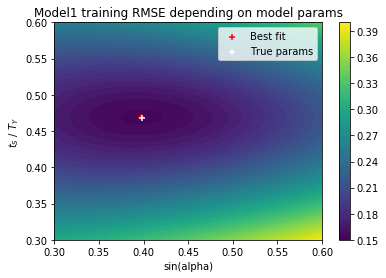

In [15]:
real_tilt = 23.44 * np.pi / 180

def plot_model1_rms(raw_data, fit_alpha, fit_soltice_yf):
    sin_alphas = np.linspace(0.3, 0.6, 5e2) ## sin alphas
    soltice_yearfs = np.linspace(0.3, 0.6, 5e2) ## solstice year_f

    C = np.zeros((np.shape(soltice_yearfs)[0], np.shape(sin_alphas)[0]))
    for m in raw_data:
        lat, lng = m['pos']
        dl_s = parse_daylight_s(m['daylight'])
        year_f = parse_year_fraction(m['date'], lng)
        tan_phi = np.tan(lat * np.pi / 180)
        night_fraction = (1 - dl_s / day_duration_s)
        z = np.cos(np.pi * night_fraction) / tan_phi
        target = z / np.sqrt(1 + z**2)
        Rn = (target -  np.matmul(np.transpose(np.mat(np.cos(2 * np.pi * (year_f - soltice_yearfs)))), np.mat(sin_alphas)))
        C += np.square(Rn)
    C = (C / N) ** 0.5

    fig, (ax0) = plt.subplots(nrows=1)
    im = ax0.contourf(sin_alphas, soltice_yearfs, C, 50)
    fig.colorbar(im, ax=ax0)
    ax0.set_title('Model1 training RMSE depending on model params')
    ax0.scatter(np.array([np.sin(fit_alpha)]), np.array([fit_soltice_yf]), marker='+', color='r', label="Best fit")
    ax0.scatter(np.array([np.sin(real_tilt)]), np.array([june21_yf]), marker='+', color='w', label="True params")
    ax0.yaxis.set_label_text('$t_S$ / $T_Y$')
    ax0.xaxis.set_label_text('sin(alpha)')
    ax0.legend()
    plt.show()

plot_model1_rms(raw_training_data, m1_alpha, m1_sf)  

A RMS error of 0.15 is rather high, given that the target values range between -1 and 1.

Let's get a visual assessment of how well our linear model fits the data. We're going to treat the solstice time $t_S$ as known from now, meaning that alpha is the only regression parameter, which will be easier to visualize:

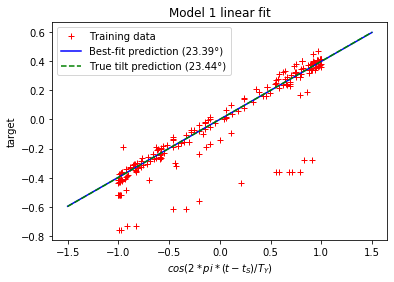

In [16]:
def plot_model1_fit_1D(raw_data, fit_alpha):
    mat = model1_design_matrix(raw_data)
    psi_sf = 2 * np.pi * june21_yf
    x_range = np.linspace(-1.5, 1.5, 100)
    plt.plot(
        np.cos(psi_sf) * mat[:,0] + np.sin(psi_sf) * mat[:,1],
        mat[:,-1],
        'r+',
        label="Training data")
    plt.plot(
        x_range,
        np.sin(fit_alpha) * x_range,
        'b',
        label="Best-fit prediction ({:.2f}°)".format(in_degrees(fit_alpha)))
    plt.plot(
        x_range,
        np.sin(real_tilt) * x_range,
        'g--',
        label="True tilt prediction ({:.2f}°)".format(in_degrees(real_tilt)))
    ax = plt.gca()
    ax.set_title('Model 1 linear fit')
    ax.set_ylabel('target')
    ax.set_xlabel('$cos(2* pi * (t - t_S) / T_Y)$')
    plt.legend()
    plt.show()

plot_model1_fit_1D(raw_training_data, m1_alpha)

We do observe a linear trend here, but do you see how far some points stretch away from the fitted curve? This is because of the $\frac{1}{\tan(\phi)}$ factor inside the target's expression. For places like Nairobi and Makassar that are close the the equator, $\tan(\phi)$ is close to $0$ and its inverse goes high, amplifying errors.

To show you how fragile our current method of regression is, let's do a small experiment. I'll add a slight imbalance to the training dataset by removing the data points of Nairobi in winter, and re-run the regression on this new dataset:

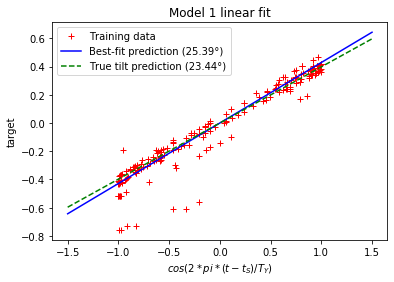

8

In [17]:
training_data_2 = [m for m in raw_training_data if (not (m['name'] == 'Nairobi' and np.cos(2 * np.pi * (parse_year_fraction(m['date'], m['pos'][1]) - june21_yf)) > 0))]
m1_alpha_2,_,_,_ = model1_fit_alpha_and_sf(training_data_2)
plot_model1_fit_1D(training_data_2, m1_alpha_2)
len(raw_training_data) - len(training_data_2)

By only removing 8 data points out of 200, our inferred value of $\alpha$ has changed by 2°!

I see this as an indication that we should question our regression method.

## Model 1 bis: non-linear least-squares regression

In this section, we'll do another form of least-squares regression, to address the limitations of the previous section. To keep things simple, we will treat the solstice time $t_S$ as a known constant from now on, and infer only the Earth's tilt $\alpha$.

Let's come back to our initial formula from Model 1:

$$ \cos(\pi (1- d_f)) =  \tan(\phi) \tan(\arcsin(\sin(\alpha) \cos(2 \pi \frac{t - t_S}{T_Y}))) $$

In the previous section, since we were aiming for linear regression, we reworked this formula so that the right-hand side could be seen as a linear combination with $\sin(\alpha)$ as a coefficient.

In this section, we're simply not going to do that: we will **treat $y := \cos(\pi (1- d_f))$ as the regression target**, with a non-linear relationship to $u := \sin(\alpha)$.

---
#### Non-linear regression for Model 1 bis: 

$$ y =  \tan(\phi) \tan(\arcsin(u \cos(\psi(t)))) $$

... in which:

* $y := \cos(\pi (1- d_f))$ _(target variable, observed)_
* $\psi(t) := 2 \pi \frac{t - t_S}{T_Y}$ _(observed)_
* $\phi$ is the latitude _(observed)_
* $u := \sin(\alpha)$ _(model parameter, to be fitted to the data)_

---


This implies that our regression is no longer linear. But that's not the end of the world: we can still do least-squares fitting, it only means that the underlying optimization problem is harder to solve.


### Implementing the regression by numerical optimization

We'll solve the optimization problem of least-squares fitting $u$ to the data using a numerical algorithm.

In [18]:
import scipy.optimize as opt

Now, the $u$ parameter space that this algorithm has to explore is really quite small - a 1-dimensional segment. So we could just use a 'brute-force' algorithm to find the best fit.

However I find it much more exciting to use an optimization algorithm that makes use of differential information such as the gradient and hessian, and it gives me an occasion to show off some symbolic computing as well. What's more, having the Hessian will prove useful in the final section, when we use the Laplace Approximation for Bayesian inference.

Indeed, I could compute the gradient and Hessian by hand from the above formula, but I'm really terrible at this sort of calculation, so I'll let the machine do it for me:

In [19]:
import sympy as sy                             ## For symbolic computing
from sympy.utilities.lambdify import lambdify  ## For converting SymPy symbolic expressions to fast NumPy operations.

First, let's define some Sympy expressions for computing our error, in terms of our data and parameters:

In [20]:
y_n, phi_n, psi_n = sy.symbols('y_n phi_n psi_n') ## data
u = sy.symbols('u') ## params

m1b_p_n = sy.tan(phi_n) * sy.tan(sy.asin(u * sy.cos(psi_n))) ## the prediction
m1b_e_n = (y_n - m1b_p_n) ** 2 ## squared error

Here is our **squared error term** for one data point:

In [21]:
m1b_e_n

(-u*cos(psi_n)*tan(phi_n)/sqrt(-u**2*cos(psi_n)**2 + 1) + y_n)**2

What amount of work can SymPy save us? As an example, let's compute one the second derivative, which will be used by our algorithm:

In [22]:
sy.diff(m1b_e_n, u, u).simplify()

-2*(3*u**2*cos(psi_n)**2*tan(phi_n) - 3*u*y_n*sqrt(-u**2*cos(psi_n)**2 + 1)*cos(psi_n) + tan(phi_n))*cos(psi_n)**2*tan(phi_n)/((u*cos(psi_n) - 1)**3*(u*cos(psi_n) + 1)**3)

Ugh, alright, I'm glad I didn't do it by hand.

Now let's implement our regression algorithm. As before, we start with a **feature engineering function:**

In [23]:
def model1b_feature_matrix(raw_data):
    rows = []
    for m in raw_data:
        lat, lng = m['pos']
        dl_s = parse_daylight_s(m['daylight'])
        year_f = parse_year_fraction(m['date'], lng)
        psi = (year_f - june21_yf) * (2 * np.pi)
        phi = lat * np.pi / 180
        night_fraction = (1 - dl_s / day_duration_s)
        y = np.cos(np.pi * night_fraction)
        rows.append([
          phi,
          psi,
          y
          ])
    return np.array(rows)

Now, we'll use `scipy.optimize` to minimize the sum of squared errors, while leaving the heavy lifting of evaluating the error and its derivatives to `sympy`. Because this is a small-dimensional problem and we have exact derivative information, we'll use the `trust-exact` method:

In [24]:
def model1b_fit_params(raw_data):
    feat_mat = model1b_feature_matrix(raw_data)

    y = feat_mat[:,2]
    phi = feat_mat[:,0]
    psi = feat_mat[:,1]
    
    e_n = m1b_e_n
    
    lam_en = lambdify([y_n, phi_n, psi_n, u], e_n)
    def squared_error(params):
        u, = params
        return np.average(lam_en(y, phi, psi, u))

    lam_jac = lambdify([y_n, phi_n, psi_n, u], sy.diff(e_n, u))
    def squared_err_jac(params):
        u, = params
        return np.array([np.average(lam_jac(y, phi, psi, u))])

    lam_hess = lambdify([y_n, phi_n, psi_n, u], sy.diff(e_n, u, u))
    def squared_err_hess(params):
        u, = params
        return np.array([[np.average(lam_hess(y, phi, psi, u))]])

    def squared_err_hessp(params, p):
        hess = np.matrix(squared_err_hess(params))
        return np.matmul(hess, p)

    opt_res = opt.minimize(
        squared_error, (0.01), 
        bounds = ((0, 1)),
        method='trust-exact', 
        jac=squared_err_jac, 
        hess=squared_err_hess
        )
    
    return opt_res

### Model 1 bis: results

Let's run the above algorithm on our training data, to see the **inferred parameter $\alpha$**:

In [25]:
m1b_optres = model1b_fit_params(raw_training_data)
m1b_u_opt, = m1b_optres.x
m1b_alpha = np.arcsin(m1b_u_opt)
print("Model 1b best-fit param is alpha = {:.2f}°, with an RMS error of {:.3f}".format(in_degrees(m1b_alpha), np.sqrt(m1b_optres.fun)))
#model2_rmse = np.sqrt(model2_optres.fun * 2)

Model 1b best-fit param is alpha = 23.79°, with an RMS error of 0.024


Our RMS error has gotten much smaller: our curve is fitting the training data more closely. Let's see if we get a much different answer on the imbalanced dataset:

In [26]:
in_degrees(np.arcsin(model1b_fit_params(training_data_2).x[0]))

23.78674413661342

As intended, our new regression method seems much less sensitive to small variations in the training dataset.

As before, let's evaluate the **test error:**

In [27]:
print("On test data, Model 1 bis achieves a Root Mean Squared prediction error of {:.1f} minutes.".format(rms_test_error(model1_daylight_predictions(raw_test_data, m1b_alpha, june21_yf), daylight_durations(raw_test_data)) / 60))

On test data, Model 1 bis achieves a Root Mean Squared prediction error of 11.0 minutes.


Unsurprisingly, our prediction accuracy hasn't improved. It's time to reach out for a less simplistic model.

## Model 2: accounting for an excess angle $\epsilon$

### Refined physical model

<img src="../img/earth-tilt-sketch.jpg" />

Let's try refining our model. We'll start from the assumption that *some phenomenon* is causing our previous Model 1 to be slightly inaccurate - it could be the fact that the Sun is not punctual, or maybe atmospheric refraction... Whatever that *some phenomenon* is, we'll assume it respects a symmetry around the Earth-Sun axis.

This means that the sunlight covers a little more than half a sphere: **it 'overflows' by a small angle $\epsilon$.** Because the Earth orbit is close to circular, we'll assume that this angle is constant over time.

In addition to the Earth tilt $\alpha$, we'll now try to infer $\epsilon$ from the data.

The geometric derivation is slightly more involved here; geometrically, the main thing to notice is that the day/night separation still lies in a plane, which is at distance $R\sin(\epsilon)$ from the Earth center. Eventually I arrived at the following formula:

$$ \cos(\pi (1 - d_f)) = \sin(\epsilon) \frac{1}{\cos(\phi)\cos(\theta(t))} + \tan(\theta(t))\tan(\phi) $$

Here we introduce some **new notation:**

* $\theta(t)$ is the angle between the Earth Equatorial Plane and the Earth-Sun axis. This angle is 0 at equinoxes, and $\pm \alpha$ at solstices.
* We define a shorthand $\psi(t) := \frac{2 \pi (t - t_S)}{T_Y}$
* It can be shown that $\sin(\theta(t)) = \sin(\alpha)\cos(\psi(t))$ (see the [physical modeling section](#Physical-Model) of Model 1)

Recalling that $cos(a) = \pm \sqrt{1 - \sin(a)^2}$, the above formula expands into:

$$ \cos(\pi (1 - d_f)) = \frac{\sin(\epsilon)}{\cos(\phi)\sqrt{1 - \sin(\alpha)^2 \cos(\psi)^2}} + \tan(\phi) \tan(\arcsin(\sin(\alpha) \cos(\psi))) $$

Compared to Model 1, we have added a new term involving $\epsilon$.

Remember, our goal is to infer $\alpha$ and $\epsilon$; we'll do that by inferring $u := \sin(\alpha)$ and $v := \sin(\epsilon)$. This yields the following **non-linear ression in parameters $u$ and $v$:**

---
#### Non-linear regression for Model 2:

$$ y = \frac{v}{\cos(\phi)\sqrt{1 - u^2 \cos(\psi)^2}} + \tan(\phi) \tan(\arcsin(u \cos(\psi))) $$

... in which:

* $y := \cos(\pi (1- d_f))$ _(target variable, observed)_
* $\psi(t) := 2 \pi \frac{t - t_S}{T_Y}$ _(observed)_
* $\phi$ is the latitude _(observed)_
* $u := \sin(\alpha)$ _(model parameter, to be fitted to the data)_
* $v := \sin(\epsilon)$ _(model parameter, to be fitted to the data)_

---

### Implementing the regression

We'll follow the same steps as for Model 1 bis.

Since our model has become more sophisticated, encoding it in SymPy is even more relevant:

In [28]:
## We don't need any new symbols for data features.
v = sy.symbols('v') ## the new parameter

m2_p_n = m1b_p_n + v / (sy.cos(phi_n) * sy.sqrt(1 - (u * sy.cos(psi_n))**2))
m2_e_n = (y_n - m2_p_n) ** 2

Here is our squared error term for one data point:

In [29]:
m2_e_n

(-u*cos(psi_n)*tan(phi_n)/sqrt(-u**2*cos(psi_n)**2 + 1) - v/(sqrt(-u**2*cos(psi_n)**2 + 1)*cos(phi_n)) + y_n)**2

Now let's implement our regression algorithm. As before, we start with a feature engineering function. In this case, we can reuse the work that we did for Model 1 bis:

In [30]:
def model2_feature_matrix(raw_data):
    return model1b_feature_matrix(raw_data)

We now write our optimization algorithm:

In [31]:
def model2_fit_params(raw_data):
    feat_mat = model2_feature_matrix(raw_data)

    y = feat_mat[:,2]
    phi = feat_mat[:,0]
    psi = feat_mat[:,1]
    
    e_n = m2_e_n
    
    lam_en = lambdify([y_n, phi_n, psi_n, u, v], e_n)
    def squared_error(params):
        u, v = params
        return np.average(lam_en(y, phi, psi, u, v))

    lam_jac_s = [lambdify([y_n, phi_n, psi_n, u, v], sy.diff(e_n, var1)) for var1 in [u, v]]
    def squared_err_jac(params):
        u, v = params
        return np.array([np.average(l(y, phi, psi, u, v)) for l in lam_jac_s])

    lam_hess_s = [[lambdify([y_n, phi_n, psi_n, u, v], sy.diff(e_n, var1, var2)) for var1 in [u, v]] for var2 in [u, v]]
    def squared_err_hess(params):
        u, v = params
        return np.array([[np.average(l(y, phi, psi, u, v)) for l in row] for row in lam_hess_s])

    def squared_err_hessp(params, p):
        hess = np.matrix(squared_err_hess(params))
        return np.matmul(hess, p)

    opt_res = opt.minimize(
        squared_error, (0.01, 0.01), 
        bounds = ((0, 1), (0, 1)),
        method='trust-exact', 
        jac=squared_err_jac, 
        hess=squared_err_hess
        )
    
    return opt_res

### Model 2: results

Let's run the above algorithm on our training data, to see the **inferred parameters**:

In [32]:
model2_optres = model2_fit_params(raw_training_data)
m2_u_opt, m2_v_opt = model2_optres.x
print("Model 2 best-fit params are alpha = {:.2f}° and epsilon = {:.2f}°".format(in_degrees(np.arcsin(m2_u_opt)), in_degrees(np.arcsin(m2_v_opt))))

Model 2 best-fit params are alpha = 23.69° and epsilon = 0.85°


We obtain a similar value of $\alpha$ as in the previous model, but a non-zero value of $\epsilon$. 

This suggests that our new model fits the training data better, which we can verify by checking the RMS error:

In [33]:
model2_rmse = np.sqrt(model2_optres.fun * 2)
model2_rmse

0.020903730648685094

So our RMS error improved by about 20%. More importantly, what is our new **test error?**

In [34]:
def model2_daylight_predictions(raw_data, u_opt, v_opt):
    feat_mat = model2_feature_matrix(raw_data)
    lam_pn = lambdify([phi_n, psi_n, u, v], m2_p_n)
    phi = feat_mat[:,0]
    psi = feat_mat[:,1]
    y = lam_pn(phi, psi, u_opt, v_opt)
    return day_duration_s * (1 - np.arccos(y) / np.pi)

print("On test data, Model 2 achieves a Root Mean Squared prediction error of {:.1f} minutes.".format(rms_test_error(model2_daylight_predictions(raw_test_data, m2_u_opt, m2_v_opt), daylight_durations(raw_test_data))  / 60))


On test data, Model 2 achieves a Root Mean Squared prediction error of 3.0 minutes.


Cool, we got our error down from 11 minutes to about 3 minutes! This suggests we have improved our prediction power.

Are we sure we found the best-fit values for our parameters, rather than a local minimum? Let's **plot our optimization landscape:**

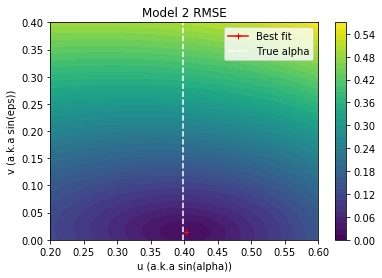

In [35]:
def plot_model2_rms(raw_data, model2_optres):
    u_opt, v_opt = model2_optres.x
    
    us = np.linspace(0.2, 0.6, 1e2)
    vs = np.linspace(0.0, 0.4, 1e2)

    C2 = np.zeros((np.shape(vs)[0], np.shape(us)[0]))
    for m in raw_data:
        lat, lng = m['pos']
        dl_s = parse_daylight_s(m['daylight'])
        year_f = parse_year_fraction(m['date'], lng)
        psi = 2 * np.pi * (year_f - june21_yf)
        phi = lat * np.pi / 180
        night_fraction = (1 - dl_s / day_duration_s)
        y = np.cos(np.pi * night_fraction)
        Rn = np.square(y - np.matmul(np.mat(vs).transpose(), np.mat((1 - (np.cos(psi) * us) ** 2) ** (-0.5) / np.cos(phi))) - np.tan(phi) * np.tan(np.arcsin(np.cos(psi) * np.matmul(np.mat(np.ones(len(vs))).transpose(), np.mat(us)))))
        C2 += Rn
    C2 = (C2 / N) ** 0.5

    fig, (ax0) = plt.subplots(nrows=1)
    im = ax0.contourf(us, vs, C2, 50)
    fig.colorbar(im, ax=ax0)
    ax0.set_title('Model 2 RMSE')
    ax0.xaxis.set_label_text('u (a.k.a sin(alpha))')
    ax0.yaxis.set_label_text('v (a.k.a sin(eps))')
    ax0.plot([u_opt], [v_opt], marker='+', color='r', label="Best fit")
    ax0.plot(np.full(len(vs), np.sin(real_tilt)), vs, color='w', linestyle='--', label="True alpha")
    ax0.legend()
    plt.show()
    
plot_model2_rms(raw_training_data, model2_optres)

This looks like a nicely convex problem, well approximated by a quadratic function, so it's no surprise that a Hessian-based algorithm quickly converged to the best solution:

In [36]:
model2_optres

     fun: 0.0002184829775163883
    hess: array([[0.87852388, 0.10733273],
       [0.10733273, 3.3509504 ]])
     jac: array([3.88037916e-06, 1.94634293e-07])
 message: 'Optimization terminated successfully.'
    nfev: 4
    nhev: 4
     nit: 3
    njev: 4
  status: 0
 success: True
       x: array([0.40171499, 0.01485877])

The above object is a `scipy.optimize` optimization result. We see that the optimization converged in only 3 iterations. Also notice that we get the best-fit point (`x`), value (`fun`) and hessian (`hess`) - these will be useful in the [section about Bayesian analysis](#Bayesian-analysis)!

### What might be causing $\epsilon$?

The most immediate explanation for $\epsilon$ is that **the Sun is not a punctual source of light** (night does not start as soon as the center of the Sun is below the horizon).

Assuming this as the explanation, a little bit of modeling and some approximations would predict that:

$$ \epsilon = \frac{R_S}{d_{ES}} $$

... in which $R_S$ is the radius of the Sun, and $d_{ES}$ is the Earth-Sun distance. In numbers:

In [37]:
R_S = 7e8
d_ES = 1.5e11
in_degrees((R_S / d_ES))

0.2673803043943842

This is much lower than the predicted 0.85°, so another physical phenomenon must be at play here. I'm not an expert, but my number 1 suspect is **atmospheric refraction**. In the future, I might extend this section to simulate it with differential equations.

## Bayesian analysis

The above analysis leaves some questions open. Model 2 fits the data better, but Model 1 is simpler, so it's not definitely clear which one we should prefer. What's more, we have found best-fit parameters for both models, but we don't know what kind of _confidence_ the models have around these inferred values - in particular, could the difference between 23.44° and 23.69° be **explained by the precision level of the inference?**

I'll approach these questions using Bayesian methods. This means that I will use a probability distribution to quantify my (our) 'belief' regarding what values our model parameters might take, and then use the observed data to update this belief based on new information, which will result in focusing this probability distribution.

---

#### Goals of our Bayesian analysis:

* Infer our model parameters **not as a punctual value, but as a _posterior probability distribution_** , giving us insights as to the precision of our regression.
* **Compare our models**, in terms of which one seems most likely given the observed data.

---

Professional data scientists would typically use specific software package for this, but for our small-scale problem Scipy will suffice, and I find it interesting to see how Scipy might be used for Bayesian analysis.

### A review of Bayesian inference

For an insightful introduction to the concepts of Bayesian inference, I recommend reading Chapter 3 of David MacKay's _[Information Theory, Inference, and Learning Algorithms](http://www.inference.phy.cam.ac.uk/mackay/itila/)_ - especially relevant here, since MacKay was a physicist! Here I'll just do a small recap of what we'll use.

Say we have a model $M_i$ for our data. This model has parameters $\Theta$, and our goal is to infer $\Theta$ from observed data $D$; I'll assume we have observed the value $D = D_0$ for the random variable $D$.

We start by choosing a **_prior distribution_** $P(\Theta | M_i)$ that we can all agree on for our parameters: this is a probability distribution which describes quantitatively what values $\Theta$ might reasonably take. $P(\Theta | M_i)$ will typically be rather broad, because we want to be open-minded about the possible values of our parameters.

We also choose a probability distribution $P(D | \Theta, M_i)$ for the observed data $D$ given the parameters $\Theta$. In the case of curve-fitting (which is what we're doing here), the observed data $D$ will typically consist of observations $(t_n, x_n)$, describe probabilistically as $t_n = f_{\Theta}(x_n) + \nu_n$, where the $\nu_n$ are independent 'noise' random variables which distribution depends on $\Theta$ (a common choice is to choose 0-mean gaussian distributions for the $\nu_n$).

Having done that, we infer our **_posterior belief_** in the parameters using Bayes' Theorem:

$$P(\Theta | D = D_0, M_i) = \frac{1}{P(D = D_0 | M_i)} P(D = D_0 | \Theta, M_i) P(\Theta | M_i)$$

In the above formula, the only factor we can't compute directly is $P(D = D_0 | M_i)$, a.k.a the **_model evidence_**. But note that it does not depend on $\Theta$, so that $\frac{1}{P(D = D_0 | M_i)}$ can be treated as a normalization constant. What's more, since $P(\Theta | D = D_0, M_i)$ is a probability density for $\Theta$ (thus summing to $1$):

$$ P(D = D_0 | M_i) = \int{P(D = D_0 | \Theta, M_i) P(\Theta | M_i) d\Theta} $$

A final point of note about the Bayesian approach is that the methodology changes: we no longer need to separate the data between a training set and a test test. We will therefore run the analyses on all the available data:

In [38]:
raw_data_all = raw_training_data + raw_test_data

### Bayesian analysis of Model 1 bis

In the case of Model 1, we define $\Theta := (u, \sigma)$ where $u = \sin(\alpha)$ and $\sigma$ is the standard deviation for the noise around observations.

We choose $P(D | \Theta, M_1)$ by saying that:

$$y_n = f_{\Theta}(\phi_n, \psi_n) + \nu_n$$ 

...where:

* $y_n := \cos(\pi (1 - d_f))$ is the 'target' variable of the regression.
* $\phi_n$ is the latitude, $\psi_n$ is the angle representing the time of the year ($\psi := 2 \pi \frac{t - t_S}{T_Y}$)
* $f_{\Theta}(\phi_n, \psi_n) := \tan(\phi_n)  \tan(\arcsin(u \cos(\psi_n)))$
* $\nu_n$ is the element of randomness: a 'noise' random variable with a 0-mean Gaussian distribution, i.e:

$$P(\nu_n | \Theta, M_1) = \frac{1}{\sqrt{2 \pi} \sigma} e^{-\frac{\nu_n^2}{2 \sigma^2}}$$

The above may seem arbitrary, but it is only reformulating our previous least-squares regression problem in probabilistic terms, so we are not really departing from Model 1. (More precisely, what we did in the least-squares regression corresponded to finding a _maximum likelihood_ estimate for $u$ in the above formula; our Bayesian analysis will yield a more nuanced answer as to what $u$ might be, as it will be a posterior probability distribution rather than a single point estimate).

Finally, we have to choose a prior $P(\Theta| M_1)$. I'll make the following assumptions, hopefully you won't find them too arbitrary:

1. Given that $u = sin(\alpha)$, I'll assume that **$u$ has a uniform distribution in $[0, 1]$.**
2. I have no precise idea of what the order of magnitude of $\sigma$ might be. Since $y_n$ ranges in $[-1,1]$, I'll assume $\sigma$ can be no higher than $1$. Since my daylight lengths are measured with the precision of 1 minute, I expect at least that level of noise on $d_f$. To be open-minded about this, I'll assume $\sigma$ can't go below $10^{-4}$. Putting all these arguments together, I'll assume that **$\log_{10}(\sigma)$ has a uniform distribution in $[-4, 0]$.**

#### SymPy representation

To help with our future computations, let's program these modeled probabilities using SymPy. Because probabilities tend to multiply, and additions are easier to handle than multiplications, we'll work with log-probabilities rather than direct probabilities.

Let's start by describing our prior distribution by defining $\ln(P(\Theta =(u, \sigma) | M_1))$:

In [39]:
sigma = sy.symbols('sigma')

u_bounds = (0, 1)
sigma_bounds = (1e-4, 1)

lp1b_theta = np.log(1 / (u_bounds[1] - u_bounds[0])) + sy.ln(1 / sigma) - np.log(np.log(sigma_bounds[1]) - np.log(sigma_bounds[0]))

lp1b_theta

log(1/sigma) - 2.22032680636785

Now we define the log-probability $\ln(P(y_n, \phi_n, \psi_n| \Theta, M_1))$ of observing a data point:

In [40]:
lp1b_n = - sy.ln(sigma) - 0.5 * np.log(2 * np.pi) - m1b_e_n / (2 * sigma**2) ## NOTE: because we have modeled our noise as a Gaussian, we can re-use our squared error expression.
lp1b_n

-log(sigma) - 0.918938533204673 - (-u*cos(psi_n)*tan(phi_n)/sqrt(-u**2*cos(psi_n)**2 + 1) + y_n)**2/(2*sigma**2)

Now let's start the work of inference.

#### Inference with the Laplace Approximation

As we saw above, exact computation of $P(\Theta | D, M_1)$ involves integrating the function $P_1^{*}(\Theta) := P(D | \Theta, M_i) P(\Theta | M_i)$. We can easily evaluate $P_1^{*}(\Theta)$ at a given point $\Theta$, but **integrals are not easy,** even for computers.

So instead of doing that, we'll first use an approximation called the **[Laplace Method](http://www.inference.org.uk/mackay/itprnn/ps/341.342.pdf)**. This approximation will turn out to be very accurate here, and will also help us do the exact integration downstream.

The Laplace Method consist at approximating $P(\Theta | D, M_1)$ by a Gaussian. To do that, we need to find a point $\Theta_{\text{MAP}}$ at which $P_1^{*}$ reaches its maximum ('MAP' stands for _Maximum A Posteriori_ ), as well as the Hessian of $P_1^{*}(\Theta)$ at $\Theta_{\text{MAP}}$, which will correspond to the precision matrix of the Gaussian.

Luckily, `scipy.optimize` gives us everything we need for doing that efficiently: we can use `scipy.optimize.minimize()` for finding $\Theta_{\text{MAP}}$ by minimizing $- \ln (P_1^{*}(\Theta))$, along with Sympy for differentiating (and in particular computing the Hessian).

I wrote a generic helper function [`find_map()`](https://github.com/vvvvalvalval/sciencey-stuff/blob/90615d901af98744d65d477b6a96b758de90cc53/utils/scipy_bayes.py#L17) for doing that in a package `utils.scipy_bayes`, which we can now apply to Model 1:

In [41]:
import utils.scipy_bayes as scp_bayes

In [42]:
def find_model1b_map(lp1b_theta, raw_data):
    mat = model1b_feature_matrix(raw_data)
    y = mat[:,-1]
    phi = mat[:, 0]
    psi = mat[:, 1]
    
    return scp_bayes.find_map(lp1b_theta, lp1b_n, [y_n, phi_n, psi_n], [u, sigma], [y, phi, psi], [0.5, 0.1], (u_bounds, sigma_bounds))

m1b_map = find_model1b_map(lp1b_theta, raw_data_all)

In [43]:
m1b_map

     fun: -525.0852242680825
    hess: array([[1.74915914e+05, 5.12161881e-04],
       [5.12161881e-04, 7.88427959e+05]])
     jac: array([-6.15855299e-06, -5.76674859e-05])
 message: 'Optimization terminated successfully.'
    nfev: 14
    nhev: 14
     nit: 13
    njev: 9
  status: 0
 success: True
       x: array([0.40248538, 0.02404924])

The above optimization result gives us the mean (`m1_map.x`) and precision matrix (`m1_map.hess`) of the approximating Gaussian. We can use these to compute 99% **_credible intervals_ for $\alpha$ and $\sigma$**. Again, we use a [small generic function](https://github.com/vvvvalvalval/sciencey-stuff/blob/90615d901af98744d65d477b6a96b758de90cc53/utils/scipy_bayes.py#L82) written for that purpose:

In [44]:
m1b_alpha_99 = [in_degrees(np.arcsin(u)) for u in scp_bayes.laplace_99_confidence_interval(m1b_map, 0)]
m1b_alpha_99

[23.34872985965773, 24.119698624931623]

#### Inference with numerical integration

We'll now compute the posterior distribution using numerical integration.

`scipy.integrate` gives us ready-made algorithms for integration, but they unfortunately have **trouble dealing with sharply-peaked integrands**, as is typically the case of $P_1^{*}(\Theta)$. We'll need to help `scipy.integrate` a bit, by pointing it at a region where most of the probability mass lies.

Fortunately, our previous work for the Laplace Approximation has already given us all we need: $\Theta_{\text{MAP}}$ tells us where the probability peak is, and the Hessian tells us the approximate dimensions of the region occupied by this peak.

Let's write a generic function for running the required integrations and plotting the posterior distribution of a model parameter:

In [45]:
import scipy.integrate as intgr

def plot_posterior(prior_logp_expr, datum_logp_expr, data_syms, theta_syms, data_values, theta0, theta_bounds, plotted_i):
    
    map_optres = scp_bayes.find_map(prior_logp_expr, datum_logp_expr, data_syms, theta_syms, data_values, theta0, theta_bounds)
    
    cov = linalg.inv(map_optres.hess)
    std_dev = np.sqrt(cov[plotted_i,plotted_i])
    mode = map_optres.x[plotted_i]
    radius = 5 * std_dev
    xs = np.linspace(mode - radius, mode + radius, 100)
    ## Laplace Approximation
    ys_lpl = np.array([np.exp(-0.5 * ((x - mode) / std_dev) ** 2) for x in xs])
    ys_lpl = ys_lpl / np.sum(ys_lpl)
    plt.plot(
            xs,
            ys_lpl,
            '',
            label="Laplace Approximation")
    
    all_syms = [] + list(data_syms) + list(theta_syms)
    lam_f_n = lambdify(all_syms, datum_logp_expr)
    lam_f_prior = lambdify(all_syms, prior_logp_expr)
    pvalues = [] + list(data_values)
    
    def f(theta):
        args = pvalues + list(theta)
        ## NOTE we're normalizing such that the density is 1 at the mode of the distribution.
        return np.exp(np.sum(lam_f_n(*args)) + lam_f_prior(*args) + map_optres.fun)

    D = len(theta_bounds)
    
    def fx(x):
        def h(*theta1):
            theta = theta1[0:plotted_i] + (x,) + theta1[plotted_i: D - 1]
            return f(theta)
        return h
    
    theta1_bounds = theta_bounds[0:plotted_i] + theta_bounds[plotted_i + 1: D]
    
    def var_intgr_opts(i):
        points = [(map_optres.x[i] + k*np.sqrt(cov[i,i])) for k in [-10, 0, 10]]
        return {'points': points}
    
    intgr_opts = [var_intgr_opts(i) for i in range(D) if i != plotted_i]
    
    def g(x):
        r, err = intgr.nquad(fx(x), theta1_bounds, opts=intgr_opts)
        return r
    
    ys_intr = np.array([g(x) for x in xs])
    ys_intr = ys_intr / np.sum(ys_intr)
    plt.plot(
            xs,
            ys_intr,
            '',
            label="Numerical Integration")
    ax = plt.gca()
    ax.set_title('Posterior probability of {}'.format(str(theta_syms[plotted_i])))
    ax.set_ylabel('Probability density')
    ax.set_xlabel(str(theta_syms[plotted_i]))
    plt.legend()
    plt.show()

Applying this to Model 1 bis:

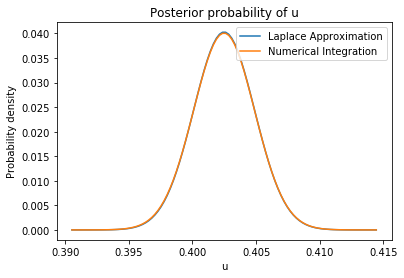

In [46]:
def plot_posterior_m1b(raw_data, var_idx):
    mat = model1b_feature_matrix(raw_data)
    y = mat[:,-1]
    phi = mat[:, 0]
    psi = mat[:, 1]
    
    theta0 = [0.5, 0.1]
    theta_bounds = (u_bounds, sigma_bounds)
    
    return plot_posterior(lp1b_theta, lp1b_n, [y_n, phi_n, psi_n], [u, sigma], [y, phi, psi],
                          [0.0, 0.1], (u_bounds, sigma_bounds),
              var_idx)

    
def plot_u_posterior_m1b(raw_data):
    return plot_posterior_m1b(raw_data, 0)


plot_u_posterior_m1b(raw_data_all)

This plot confirms that the Laplace Approximation worked really well for $u$.

Let's do the same for $\sigma$:

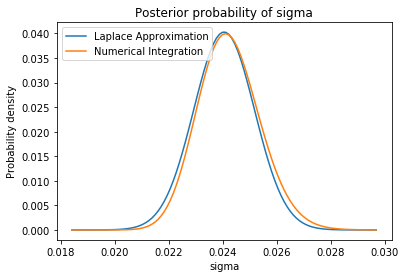

In [47]:
def plot_sigma_posterior_m1b(raw_data):
    return plot_posterior_m1b(raw_data, 1)


plot_sigma_posterior_m1b(raw_data_all)

Here the Laplace Approximation looks just slightly less effective.

#### Bayesian analysis of Model 1 (linear regression)

When we did the linear regression from Model 1, I claimed that the regression result was not a precise one. Let's use Bayesian analysis to quantify that more rigorously.

As before, we'll use the Laplace Method to find the posterior distribution of parameters:

In [48]:
z_n, x_n = sy.symbols('z_n x_n') ## target of the linear regression

lp1_theta = np.log(1 / (u_bounds[1] - u_bounds[0])) + sy.ln(1 / sigma) - np.log(np.log(sigma_bounds[1]) - np.log(sigma_bounds[0]))

m1_p_n = u * x_n
m1_e_n = (z_n - m1_p_n)**2
lp1_n = - sy.ln(sigma) - 0.5 * np.log(2 * np.pi) - m1_e_n / (2 * sigma**2)

def find_model1_map(raw_data):
    psi_sf = 2 * np.pi * june21_yf

    mat = model1_design_matrix(raw_data)
    x = np.cos(psi_sf) * mat[:,0] + np.sin(psi_sf) * mat[:,1]
    z = mat[:,-1]
    
    return scp_bayes.find_map(lp1_theta, lp1_n, [z_n, x_n], [u, sigma], [z, x], [0.0, 0.1], (u_bounds, sigma_bounds))
    
m1_map = find_model1_map(raw_data_all)
m1_alpha_99 = [in_degrees(np.arcsin(u)) for u in scp_bayes.laplace_99_confidence_interval(m1_map, 0)]
m1_alpha_99

[21.412133271735936, 25.935786290415102]

This supports my claim: our credible interval for $\alpha$ using linear regression is more than 5 times wider than using non-linear regression!

To make this more visual, let's plot jointly the posterior distributions for both regression methods:

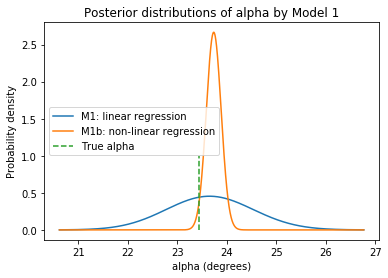

In [49]:
def plot_m1_alpha_posteriors(m1_map, m1b_map):
    ## NOTE we'll be using the Laplace Approximation here, since we've seen that it is quite accurate for these inferred parameters.
    
    def gaussian_params(map_optres, plotted_i):
        cov = linalg.inv(map_optres.hess)
        std_dev = np.sqrt(cov[plotted_i,plotted_i])
        mode = map_optres.x[plotted_i]
        return (mode, std_dev)
        
        
    ## Choosing the plotted region
    
    def plotted_interval(map_optres, plotted_i):
        mode, std_dev = gaussian_params(map_optres, plotted_i)
        radius = 3.5 * std_dev
        return (mode - radius, mode + radius)
    
    m1_low, m1_high = plotted_interval(m1_map, 0)
    m1b_low, m1b_high = plotted_interval(m1b_map, 0)
    
    plotted_low = min(m1_low, m1b_low)
    plotted_high = max(m1_high, m1b_high)

    us = np.linspace(plotted_low, plotted_high, 2000)
    
    
    ## Plotting

    # This time we'll be plotting the posterior of alpha itself in degrees, rather than sin(alpha),
    # which requires a density conversion.
    def to_angle_density(sin_xs, p_sin_xs):
        xs = in_degrees(np.arcsin(sin_xs))
        p_xs = p_sin_xs * np.abs(np.cos(xs * np.pi / 180)) * np.pi / 180
        return (xs, p_xs)

    def plot_posterior(regr_method_name, map_optres, plotted_i):
        mode, std_dev = gaussian_params(map_optres, plotted_i)

        ys_lpl = np.exp(-0.5 * ((us - mode) / std_dev) ** 2)/ (np.sqrt(2 * np.pi) * std_dev)
        alphas, p_alphas = to_angle_density(us, ys_lpl)
        plt.plot(alphas, p_alphas, '', label=regr_method_name)
        
    plot_posterior("M1: linear regression" , m1_map, 0)
    plot_posterior("M1b: non-linear regression" , m1b_map, 0)
    
    plt.plot(np.ones(100) * in_degrees(real_tilt), np.linspace(0, 1.0, 100), '--', label='True alpha')
    
    ax = plt.gca()
    ax.set_title('Posterior distributions of alpha by Model 1')
    ax.set_ylabel('Probability density')
    ax.set_xlabel('alpha (degrees)')
    plt.legend()
    plt.show()
    
plot_m1_alpha_posteriors(m1_map, m1b_map)

### Bayesian analysis of Model 2

Our definition of Model 2 is very similar to Model1, with 2 differences:

1. We add a parameter $v$, such that $\Theta := (u, v, \sigma)$. Similarly to $u$, because $v := \sin(\epsilon)$, our prior distribution for $v$ is uniform on $[0, 1]$.
2. Our basis function $f_\Theta$ is more complex: 

$$f_{\Theta}(\phi_n, \psi_n) := \frac{v}{\cos(\phi_n)\sqrt{1 - u^2 \cos(\psi_n)^2}} + \tan(\phi_n)  \tan(\arcsin(u \cos(\psi_n)))$$

We'll now do the analysis by following the same steps as Model 1.

We represent our log-probabilities using SymPy:

In [50]:
v_bounds = (0, 1)

lp2_theta = np.log(1 / (u_bounds[1] - u_bounds[0])) + np.log(1 / (v_bounds[1] - v_bounds[0])) + sy.ln(1 / sigma) - np.log(np.log(sigma_bounds[1]) - np.log(sigma_bounds[0]))
lp2_theta

log(1/sigma) - 2.22032680636785

In [51]:
lp2_n = - sy.ln(sigma) - 0.5 * np.log(2 * np.pi) - m2_e_n / (2 * sigma**2)
lp2_n

-log(sigma) - 0.918938533204673 - (-u*cos(psi_n)*tan(phi_n)/sqrt(-u**2*cos(psi_n)**2 + 1) - v/(sqrt(-u**2*cos(psi_n)**2 + 1)*cos(phi_n)) + y_n)**2/(2*sigma**2)

We now find the MAP parameters:

In [52]:
def find_model2_map(lp2_theta, raw_data):
    feat_mat = model2_feature_matrix(raw_data)
    
    y = feat_mat[:,2]
    phi = feat_mat[:,0]
    psi = feat_mat[:,1]
    
    theta0 = (0.5, 0.1, 0.1)
    theta_bounds = (u_bounds, v_bounds, sigma_bounds)
    
    return scp_bayes.find_map(lp2_theta, lp2_n, [y_n, phi_n, psi_n], [u, v, sigma], [y, phi, psi], theta0, theta_bounds)

m2_map = find_model2_map(lp2_theta, raw_data_all)
m2_map

     fun: -648.3715778079645
    hess: array([[ 5.14364566e+05,  5.23936866e+04,  2.26264820e-06],
       [ 5.23936866e+04,  1.94384673e+06, -1.63605728e-06],
       [ 2.26264820e-06, -1.63605728e-06,  2.32505800e+06]])
     jac: array([-1.58433977e-08,  1.14559953e-08, -2.44203534e-07])
 message: 'Optimization terminated successfully.'
    nfev: 16
    nhev: 16
     nit: 15
    njev: 11
  status: 0
 success: True
       x: array([0.40117087, 0.01513473, 0.01400443])

We can now use the Laplace Approximation to get credible intervals for $\alpha$ and $\epsilon$:

In [53]:
m2_alpha_99 = [in_degrees(np.arcsin(u)) for u in scp_bayes.laplace_99_confidence_interval(m2_map, 0)]
m2_alpha_99

[23.42662879145868, 23.876549453042667]

In [54]:
m2_eps_99 = [in_degrees(np.arcsin(v)) for v in scp_bayes.laplace_99_confidence_interval(m2_map, 1)]
m2_eps_99

[0.7611783672021385, 0.9732026944052911]

Let's now plot the posterior distributions for our parameters:

In [55]:
def plot_posterior_m2(lp2_theta, raw_data, var_idx):
    feat_mat = model2_feature_matrix(raw_data)
    
    y = feat_mat[:,2]
    phi = feat_mat[:,0]
    psi = feat_mat[:,1]
    
    theta0 = (0.5, 0.1, 0.1)
    theta_bounds = (u_bounds, v_bounds, sigma_bounds)
    
    return plot_posterior(lp2_theta, lp2_n, [y_n, phi_n, psi_n], [u, v, sigma], 
              [y, phi, psi], theta0, theta_bounds,
              var_idx)

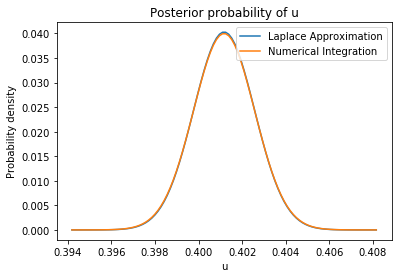

In [56]:
def plot_u_posterior_m2(lp2_theta, raw_data):
    return plot_posterior_m2(lp2_theta, raw_data, 0)
    
plot_u_posterior_m2(lp2_theta, raw_data_all)

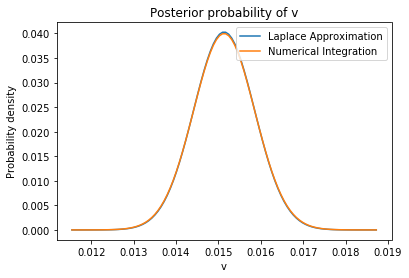

In [57]:
def plot_v_posterior_m2(lp2_theta, raw_data):
    return plot_posterior_m2(lp2_theta, raw_data, 1)

plot_v_posterior_m2(lp2_theta, raw_data_all)

On my machine, these commands took much longer to execute, as they now involve integration in 3D. We start understanding why Bayesian data scientists use specialized integration tools! (or approximations).

### Model comparison

Bayesian methods can also help us assess our preference between several models. We'll do that with two approaches: _ROPEs_ and _model evidence_.

#### Via credible intervals and ROPEs

Notice that Model 1b is equivalent to a constrained version of Model 2: namely, Model 1b is like Model2 with $\epsilon = 0$.

From this, we can already sense that Model 2 is "superior" to Model 1b, in that $\epsilon = 0$ falls outside of our 99% highest-density interval for $\epsilon$, as we saw above.

More rigourously, we can decide on a _Range Of Practical Equivalence_ (ROPE) for $\epsilon = 0$, which is an interval of values for $\epsilon$ which we consider practically equivalent to $\epsilon = 0$. If this ROPE is disjoint from our 99% highest-density interval for $\epsilon$, then we can confidently say that the data favour Model 2 over Model 1b.

What's a good size for our ROPE? Let's see. Our data for day lengths have 1-minute resolution; a 1-day rotation corresponds to an angular speed of 0.25°/minute, so 0.25° seems like the right order of magnitude for a perceptible effect of $\epsilon$; let's amplify that 2x to be safe. Therefore, $\epsilon \in [0°, 0.5°]$ seems like quite a tolerant ROPE for $\epsilon = 0$.

We already established a 99% credible interval for $\epsilon$:

In [58]:
m2_eps_99

[0.7611783672021385, 0.9732026944052911]

Our ROPE falls outside of this interval, leading us to reject Model 1b in favour of Model 2.

#### Via Model Evidence

Bayesian methods can also help us assess our preference between several models, by computing the _model evidence_ $P(D | M_i)$. If a model has more evidence than another, we trust it more.

As we saw above, the model evidence can be computed as:

$$ P(D | M_i) = \int{P^*_i(\Theta) d\Theta} $$

in which $P^*_i(\Theta) := P(D | \Theta, M_i) P(\Theta | M_i)$, and is easy to compute.

Model 2 is strictly more expressive than Model 1b, and therefore the evidence of Model 2 will have a data-fit advantage. On the other hand, Model 2 has a larger parameter space and therefore broader prior, therefore its evidence should suffer a complexity penalty.


#### Informed priors

To make a fair comparison between models, their prior should be equally informed. To that end, we will make a new split of the dataset, using a minority (20%) of the data to inform the priors of both models:

In [59]:
def split_all_data(raw_data_all):
    raw_data_all2 = ([] + raw_data_all)
    random.shuffle(raw_data_all2)

    i = round(len(raw_data_all2) * 0.2)
    return (raw_data_all2[0:i], raw_data_all2[i+1:len(raw_data_all2)])

(raw_data1, raw_data2) = split_all_data(raw_data_all)

We then use a part of the data to compute _"informed"_ prior distributions; because we're only trying to get the prior distributions in the right "ballpark" of realistic parameters, we'll feel free to use the Laplace Method to approximate these informed priors as Gaussian distributions.

Again, we'll use a little helper function `scp_bayes.laplace_posterior_logp_expr` which returns a SymPy expression: 

In [60]:
lpi1b_theta = scp_bayes.laplace_posterior_logp_expr([u, sigma], find_model1b_map(lp1b_theta, raw_data1))
lpi2_theta = scp_bayes.laplace_posterior_logp_expr([u, v, sigma], find_model2_map(lp2_theta, raw_data1))

In [61]:
lpi1b_theta

-58099.9290270411*sigma**2 - 4.51944572432694e-7*sigma*u + 3269.61571793428*sigma - 10205.8491587791*u**2 + 8210.66973875858*u - 1688.42825340216

In [62]:
lpi2_theta

-139957.946151117*sigma**2 - 2.43364852394734e-5*sigma*u + 5.53267782379407e-5*sigma*v + 5074.66871155449*sigma - 24490.1256050506*u**2 - 509.894247078948*u*v + 19717.8966924201*u - 109195.211279726*v**2 + 3967.3729936139*v - 4032.24399339279

For the sake of accuracy, we must now re-compute MAP optimization results from these informed priors:

In [63]:
m1b_i_map = find_model1b_map(lpi1b_theta, raw_data2)
m2_i_map = find_model2_map(lpi2_theta, raw_data2)
m2_i_map

     fun: -546.5257800514913
    hess: array([[ 532708.2154319 ,   63084.4392366 ,  -11250.29934774],
       [  63084.4392366 , 1982737.78657592,  -72263.50238069],
       [ -11250.29934774,  -72263.50238069, 2041879.06117612]])
     jac: array([ 8.93578544e-11,  4.26325641e-12, -7.28505256e-10])
 message: 'Optimization terminated successfully.'
    nfev: 13
    nhev: 13
     nit: 12
    njev: 9
  status: 0
 success: True
       x: array([0.40089469, 0.01504505, 0.013209  ])

These 'new' MAP results are highly similar to those we computed above: essentially, all we did differently was applying Bayes' formula in two steps instead of one, and doing some approximation and re-normalization in-between.

#### Using the Laplace approximation

The Laplace Appriximation also gives us an efficient approximation for computing the model evidence: since $P^*_i(\Theta)$ is approximated to be an un-normalized gaussian, we only need to compute the scaling factor for a gaussian, which can be done analytically.

As before, I wrote a small [generic function for computing the model evidence](https://github.com/vvvvalvalval/sciencey-stuff/blob/90615d901af98744d65d477b6a96b758de90cc53/utils/scipy_bayes.py#L72), which we can apply directly to our MAP optimization results:

In [64]:
m1b_lapl_logev = scp_bayes.laplace_log_evidence(m1b_i_map)
m2_lapl_logev = scp_bayes.laplace_log_evidence(m2_i_map)

print("By the Laplace approximation, there is {} times more evidence for Model 2 than for Model 1b".format(
    np.exp(m2_lapl_logev - m1b_lapl_logev)))

By the Laplace approximation, there is 4.622783860195927e+45 times more evidence for Model 2 than for Model 1b


There is **overwhelmingly more evidence for Model 2 than Model 1**, which is not too surprising given how much better it fits the data.

#### Discussion: credibility of our noise

We saw above that Model 2 is much more credible than Model 1; however, keep in mind that both models might have much less evidence than some other model we would come up with.

In particular, in this case, **the hypothesis of i.i.d zero-mean Gaussian noise for explaining errors is very questionable**. We made this assumption because it's a natural probabilitic interpretation for least-squares regression; but is it consistent with the data?

To answer, let's get a synthetic visualization of our noise, by plotting the sign of the prediction error at each datum:

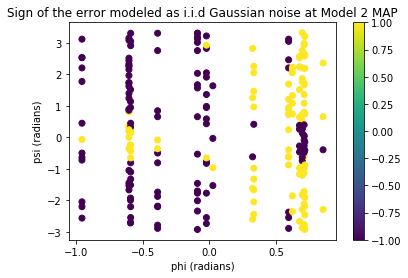

In [65]:
from sympy.utilities.lambdify import lambdify

def plot_model2_errors(m2_map, raw_data):
    feat_mat = model2_feature_matrix(raw_data)
    
    y = feat_mat[:,2]
    phi = feat_mat[:,0]
    psi = feat_mat[:,1]
    
    
    u_map, v_map, sigma_map = m2_map.x
    
    err_expr = ((y_n - m2_p_n) / sigma) ## Note we display only the sign of the error to get more contrast.
    compute_err = lambdify([u, v, sigma, phi_n, psi_n, y_n], err_expr)
    errs = compute_err(u_map, v_map, sigma_map, phi, psi, y)
    
    fig, ax = plt.subplots()
    sc = ax.scatter(phi, psi, c=np.sign(errs))#, s=np.abs(errs) * 50)
    cb = fig.colorbar(sc, ax=ax)
    ax.set_title('Sign of the error modeled as i.i.d Gaussian noise at Model 2 MAP')
    ax.set_xlabel('phi (radians)')
    ax.set_ylabel('psi (radians)')
    plt.show()
    
plot_model2_errors(m2_map, raw_data_all)

If the noise was truly random and i.i.d, we should be seeing white noise here, like static on analog TV. But in fact, we observe quite a bit of continuity here, and it appears that the latitude (`phi`) is good predictor of the sign of our error. Our errors are much less random than our model expected.

From this, we can conclude that our modeling work is not done, and we should not be satisfied with Model 2.

## Confession: the math error in the model

When I first started writing my experiments into this notebook, I had made a geometry error when modeling the physics of the problem. I had seen a $\sin(\theta)$ where I should have seen $\tan(\theta)$, leading to the following model:

$$ \frac{\cos(\pi (1 - d_f))}{\tan(\phi)} = \sin(\alpha) \cos\left(2 \pi \frac{t - t_S}{T_Y}\right) $$

(Correcting this error consisted in wrapping the right-hand side in $\tan(\arcsin(...))$)

This model, and its extension analogous to model 2, consistently predicted an Earth tilt of about 25.5° rather than 23.5° - but I only knew that was a problem because I was 'cheating': in a real world situation, I would not have known the true value of $\alpha$. (what then would have been the point of inferring it?)

Aside from that, my mathematically erroneous models fitted the data just as well, with similar prediction errors on test data, and similar evidence and posterior distribution widths in the Bayesian analysis. **From the analysis results alone, the faulty models looked just as credible and confident as the corrected ones.**

To be fair, most mathematical errors in modeling would result in more spectacular effects in data analysis. In this case, a $\tan$ was mistaken for a $\sin$, but these two functions are pretty close for small angles.

That said, I see 2 takeways from this:

1. **Because a model is confident, does not mean it's right.** A model can predict very well without representing reality.
2. When modeling, **write things down carefully.** Trying to explain my mathematical derivation was how I realized my mistake. "Writing is nature's way of letting you know how sloppy your thinking is."

## Conclusion

Without telescopes, and using only a small sample of data from everyday weather services on the Internet, we've been able to estimate the Earth's tilt to a precision of about 0.3°.

A **small recap:**
* We started with a simple physical model (Model 1), and fitted it to the data using **least-squares linear regression**.
* We then discarded linear regression as too fragile. We turned too **non-linear least-squares regression** instead, and implemented it using numerical optimization assisted by symbolic computing. The robustness of the estimation improved, but not the prediction error.
* We came up with a **more sophisticated physical model (Model 2)**, and fitted it with non-linear least squares as well.
* We refined our analysis through **Bayesian inference**, using first the **Laplace Approximation**, then **numerical integration**.
* Both the prediction error and Bayesian analysis depicted Model 2 as superior.

Some **lessons learned:**
* When doing regression, linearity should not be pursued at all costs. Optimizations algorithm can be very effective at implementing non-linear regression. The a choice of regression method should be made to match the reality of error patterns.
* Bayesian analysis offers interesting methods for assessing our confidence in our analyses, and can be easy to implement without specialized tools.
* A model can have a high predictive power without representing reality.
* Theoretical modeling is tricky (for me at least), writing things down carefully can help.
* Science on a computer is fun!

I hope you found this interesting. I am fairly new to most of the tools and techniques mentioned here; suggestions for improvement are welcome.